<a href="https://colab.research.google.com/github/shreyab1111/MultiLexNorm-Challenge/blob/main/English/en_ln_seq2seq_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade -qq tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf 
print(tf.__version__)

2.6.0


In [3]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input,LSTM
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re

In [5]:
epochs = 150  # Number of epochs to train for.
num_samples = 30000
data_path = '/content/drive/MyDrive/NLP/Lexical Normalisation/Multilexnorm Challenge/English/train.norm.txt'

In [6]:
# Vectorize the data.
input_texts = []
target_texts = []
text_pairs = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
for line in lines[: min(num_samples, len(lines) - 1)]:
  if line=='\n':
    continue
  else:
    input_text, target_text= line.split("\t")
    if target_text[-2:]!='\n':
      target_text = "[start] " + ' '.join([i for i in target_text[:-1]]) + " [end]"
    else:
      target_text = "[start] " + ' '.join([i for i in target_text]) + " [end]"
    #input_texts.append(input_text)
    #target_texts.append(target_text)
    text_pairs.append((' '.join([i for i in input_text]), target_text))

In [7]:
for _ in range(5):
    print(random.choice(text_pairs))

('.', '[start] . [end]')
('@ n b a f o l l o w t r a i n', '[start] @ n b a f o l l o w t r a i n [end]')
('# b l o o m b e r g', '[start] # b l o o m b e r g [end]')
('s e r g e', '[start] s e r g e [end]')
('t h i s', '[start] t h i s [end]')


In [8]:
len(text_pairs)

28122

In [9]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

28122 total pairs
19686 training pairs
4218 validation pairs
4218 test pairs


In [10]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 70
sequence_length = 45
batch_size = 64

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [12]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_input_texts)
spa_vectorization.adapt(train_output_texts)

In [13]:
print(train_input_texts[:15])
print(train_output_texts[:15])

['s m a s h', 'd e f i n i t e l y', 'g', "t h a t ' s", 'o h', 's h i t', 'b o r i n g', '@ c 0 c k e a t e r', 'k n o w', 'm c s', 'm o s t', 'h t t p : / / t . c o / x i q v b 3 f m 5 d', 'n i c e', 'g u y s', 'r e t w e e t']
['[start] s m a s h [end]', '[start] d e f i n i t e l y [end]', '[start] g [end]', "[start] t h a t ' s [end]", '[start] o h [end]', '[start] s h i t [end]', '[start] b o r i n g [end]', '[start] @ c 0 c k e a t e r [end]', '[start] k n o w [end]', '[start] m c s [end]', '[start] m o s t [end]', '[start] h t t p : / / t . c o / x i q v b 3 f m 5 d [end]', '[start] n i c e [end]', '[start] g u y s [end]', '[start] r e t w e e t [end]']


In [14]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

In [15]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [16]:
print(train_ds)
print(val_ds)

<CacheDataset shapes: ({encoder_inputs: (None, 45), decoder_inputs: (None, 45)}, (None, 45)), types: ({encoder_inputs: tf.int64, decoder_inputs: tf.int64}, tf.int64)>
<CacheDataset shapes: ({encoder_inputs: (None, 45), decoder_inputs: (None, 45)}, (None, 45)), types: ({encoder_inputs: tf.int64, decoder_inputs: tf.int64}, tf.int64)>


In [17]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 45)
inputs["decoder_inputs"].shape: (64, 45)
targets.shape: (64, 45)


In [18]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
            'attention': self.attention,
            'dense_proj': self.dense_proj,
            'layernorm_1': self.layernorm_1,
            'layernorm_2': self.layernorm_2,
            'supports_masking': self.supports_masking,
        })
        return config

In [19]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'vocab_size': self.vocab_size,
            'sequence_length': self.sequence_length,
            'position_embeddings': self.position_embeddings,
            'token_embeddings': self.token_embeddings,
        })
        return config

In [20]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
            'attention_1': self.attention_1,
            'attention_2': self.attention_2,
            'dense_proj' : self.dense_proj,
            'layernorm_1': self.layernorm_1,
            'layernorm_2': self.layernorm_2,
            'layernorm_3' : self.layernorm_3,
            'supports_masking' : self.supports_masking,
        })
        return config

In [21]:
embed_dim = 68
latent_dim = 32
num_heads = 4

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [22]:
transformer.summary()
transformer.compile(
    'rmsprop', loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 68)     7820        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 68)     79592       positional_embedding[0][0]       
________________________________________________________________________________________

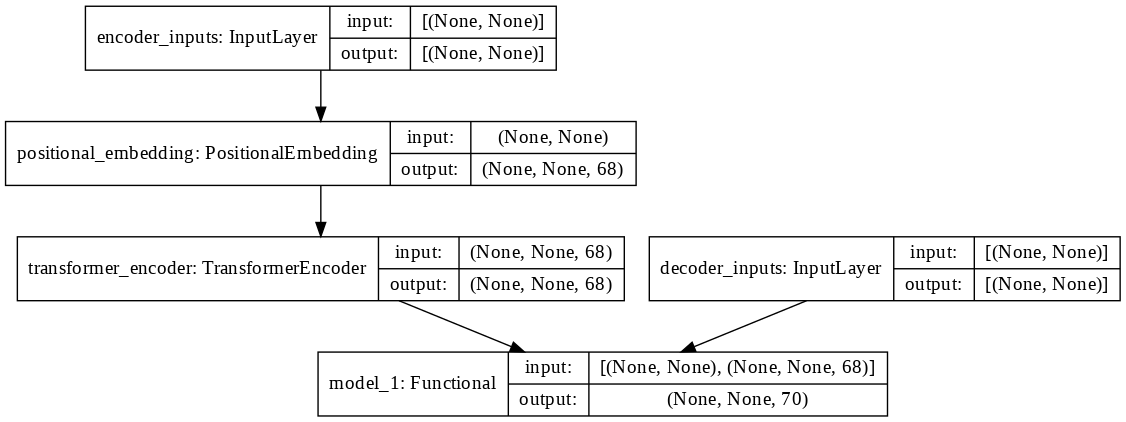

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(
    transformer,
    to_file="ln_transformer.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

In [24]:
transformer.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds)

Epoch 1/150
308/308 [==============================] - 15s 25ms/step - loss: 0.0666 - accuracy: 0.9174 - val_loss: 0.0251 - val_accuracy: 0.9658
Epoch 2/150
308/308 [==============================] - 7s 23ms/step - loss: 0.0258 - accuracy: 0.9680 - val_loss: 0.0196 - val_accuracy: 0.9726
Epoch 3/150
308/308 [==============================] - 7s 22ms/step - loss: 0.0217 - accuracy: 0.9718 - val_loss: 0.0181 - val_accuracy: 0.9746
Epoch 4/150
308/308 [==============================] - 7s 22ms/step - loss: 0.0193 - accuracy: 0.9743 - val_loss: 0.0156 - val_accuracy: 0.9777
Epoch 5/150
308/308 [==============================] - 7s 23ms/step - loss: 0.0172 - accuracy: 0.9768 - val_loss: 0.0145 - val_accuracy: 0.9799
Epoch 6/150
308/308 [==============================] - 7s 22ms/step - loss: 0.0160 - accuracy: 0.9784 - val_loss: 0.0141 - val_accuracy: 0.9801
Epoch 7/150
308/308 [==============================] - 7s 22ms/step - loss: 0.0148 - accuracy: 0.9799 - val_loss: 0.0141 - val_accuracy

In [25]:
transformer.save('/content/drive/MyDrive/NLP/Lexical Normalisation/models/en_ln_transformer.h5')

In [26]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 45


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, ' ',translated)

@ j a i b r o o k s 1   [start] j a i b r o o k s 1 [end]
c a n c e l l i n g   [start] c a n c e l l i n g [end]
.   [start] [end]
m e   [start] m e [end]
h o t t i e   [start] h o t t i e [end]
,   [start] [end]
u   [start] y o u [end]
r a i n   [start] r a i n [end]
k r e m e   [start] k r e m e [end]
k u r a n g   [start] k u r a n g [end]
y   [start] y [end]
t r u s t   [start] t r u s t [end]
h a v e   [start] h a v e [end]
f o r   [start] f o r [end]
f x   [start] f x [end]
h t t p : / / t . c o / w b x 9 h 8 j n d m   [start] h t t p t c o w b x 9 h 8 j n d m [end]
m e g a m a l l   [start] m e g a m a l l [end]
a p   [start] a p [end]
p u t   [start] p u t [end]
m o v i e   [start] m o v i e [end]
i g n o r a n c e   [start] i g n o r a n c e [end]
,   [start] [end]
w i t h   [start] w i t h [end]
y a h o o   [start] y a h o o [end]
j a p a n   [start] j a p a n [end]
m e   [start] m e [end]
h t t p : / / t . c o / k k n 8 3 w t u w s   [start] h t t p t c o k k n 8 3 w t u w 

In [ ]:
spa_index_lookup

{0: '',
 1: '[UNK]',
 2: '[start]',
 3: '[end]',
 4: 'e',
 5: 't',
 6: 'a',
 7: 'o',
 8: 'i',
 9: 'n',
 10: 's',
 11: 'r',
 12: 'h',
 13: 'l',
 14: 'm',
 15: 'd',
 16: 'u',
 17: 'c',
 18: 'y',
 19: 'g',
 20: 'p',
 21: 'w',
 22: 'b',
 23: 'f',
 24: 'k',
 25: 'v',
 26: 'j',
 27: 'x',
 28: 'z',
 29: '1',
 30: '0',
 31: '2',
 32: '5',
 33: 'q',
 34: '4',
 35: '3',
 36: '7',
 37: '8',
 38: '9',
 39: '6',
 40: ']',
 41: '['}

In [ ]:
eng_vocab = eng_vectorization.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
eng_index_lookup

{0: '',
 1: '[UNK]',
 2: 'e',
 3: 't',
 4: 'a',
 5: 'o',
 6: 'i',
 7: 'n',
 8: 's',
 9: 'r',
 10: 'h',
 11: 'l',
 12: 'm',
 13: 'd',
 14: 'u',
 15: 'c',
 16: 'y',
 17: 'p',
 18: 'g',
 19: 'w',
 20: 'b',
 21: 'f',
 22: 'k',
 23: 'v',
 24: 'j',
 25: 'x',
 26: 'z',
 27: '1',
 28: '0',
 29: '2',
 30: '5',
 31: 'q',
 32: '4',
 33: '3',
 34: '7',
 35: '8',
 36: '9',
 37: '6'}